In [1]:
import os
import sys
import cv2
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
src_dir = os.path.join("../src")
sys.path.insert(0, src_dir)
from dataloader import FrameDataLoader
from dataloader.transform import *

In [2]:
img = cv2.imread('../data/anonymisedVideos/-43p5IQaY18_000383_000393_0.jpg')
imgs = np.expand_dims(img, axis=0) 

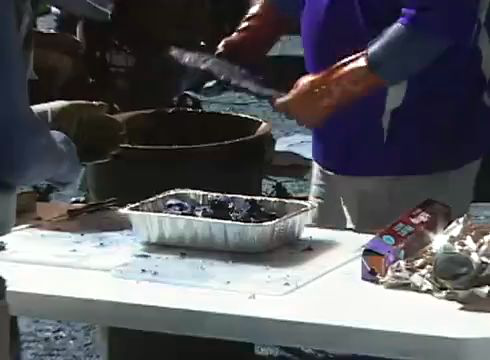

In [3]:
# B, H, W, C
frames = np.transpose(imgs, (0, 3, 1, 2))
Image.fromarray(img)

In [4]:
img_shape = frames.shape
resize_factor = random.uniform(0.8, 1.2)
resized = np.zeros((1, img_shape[1], int(img_shape[2]*resize_factor), int(img_shape[3]*resize_factor)))
for n, i in enumerate(frames):
    resized[n, :, :, :] = resize(
        frames[n, :, :, :], resized.shape[1:], anti_aliasing=True)
frames = resized
frames.shape

(1, 3, 304, 413)

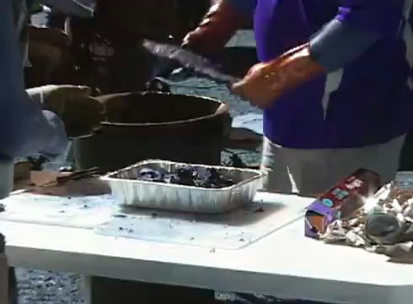

In [5]:
res = np.transpose(frames, (0, 2, 3, 1))
Image.fromarray((res[0]*255).astype(np.uint8))

with open("../data/anonymisedVideos/types.json", "r") as f:
    cls_types = json.load(f)
labels = pd.read_csv('../data/anonymisedVideos/videos.csv', index_col="name")

def get_start_end_idx(video_size, clip_size, clip_idx, num_clips):
    delta = max(video_size - clip_size, 0)
    start_idx = delta * clip_idx / num_clips
    end_idx = start_idx + clip_size - 1
    return start_idx, end_idx

file_list = list(Path("../data/anonymisedVideos").glob("*.jpg"))
temp_files = dict(zip(map(lambda x: x.stem, file_list),
                map(lambda x: str(x), file_list)))

files = {}
for (k, v) in temp_files.items():
    ksplit = k.split("_")
    video_name, frame_id = "_".join(ksplit[:-1]), int(ksplit[-1])
    if not video_name in files:
        files[video_name] = {}
    files[video_name][frame_id] = v

temp_files = {}
for k in files.keys():
    files[k] = sorted(files[k].items())
    video_fps = int(labels.loc[k]['fps'])
    video_size = len(files[k])
    if(video_size > 12 * video_fps):
        split_num = video_size // (12 * video_fps)
        for x in range(0, split_num+1):
            start_idx, end_idx = get_start_end_idx(video_size, 12 * video_fps, x, split_num)
            temp_files["%s/%d"%(k, x)] = files[k][round(start_idx):round(end_idx)]
    else:
        temp_files[k] = files[k]
files = collections.OrderedDict(temp_files)

In [10]:
batch_size = 15
dl = FrameDataLoader("../data/anonymisedVideos", [224, 224], 15, 5, 12)
print(dl.__len__())

1788


In [11]:
types = (tf.float32, tf.int32, tf.int32)
ds = tf.data.Dataset.from_generator(dl, output_types=types)
ds = ds.batch(batch_size)

In [12]:
X, frame_idx, y = next(iter(ds))
print(X.shape, frame_idx, y)

(15, 15, 224, 224, 3) tf.Tensor(
[[  0   8  17  26  35  44  53  62  70  79  88  97 106 115 124]
 [ 14  23  32  41  49  58  67  76  85  94 103 111 120 129 138]
 [ 29  37  46  55  64  73  82  91  99 108 117 126 135 144 153]
 [ 43  52  61  70  78  87  96 105 114 123 132 140 149 158 167]
 [ 58  66  75  84  93 102 111 120 128 137 146 155 164 173 182]
 [ 72  81  90  99 107 116 125 134 143 152 161 169 178 187 196]
 [ 87  95 104 113 122 131 140 149 157 166 175 184 193 202 211]
 [101 110 119 128 136 145 154 163 172 181 190 198 207 216 225]
 [116 124 133 142 151 160 169 178 186 195 204 213 222 231 240]
 [130 139 148 157 165 174 183 192 201 210 219 227 236 245 254]
 [145 153 162 171 180 189 198 207 215 224 233 242 251 260 269]
 [159 168 177 186 194 203 212 221 230 239 248 256 265 274 283]
 [  0   8  17  26  35  44  53  62  70  79  88  97 106 115 124]
 [ 14  23  32  41  49  58  67  76  85  94 103 111 120 129 138]
 [ 29  37  46  55  64  73  82  91  99 108 117 126 135 144 153]], shape=(15, 15), dtyp

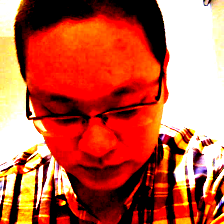

In [13]:
Image.fromarray((X[0][0].numpy()*255).astype(np.uint8))